In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%run cleaning_ucdp.ipynb

In [168]:
country = "sri_lanka"
ucleaner = UCDPCleaner(country)

ucleaner.load_data(use_high=True, full_path=None)
data_duration = ucleaner.duration()
ucleaner.set_data(data_duration)

date = "06-01-2011"
cut = ucleaner.cut_off_end(date)
ucleaner.set_data(cut)


Loading data from ../data/ucdp/sri_lanka.csv
Loading data from ../data/ucdp/sri_lanka.csv


dates range from 1989-01-01 to 2011-01-22


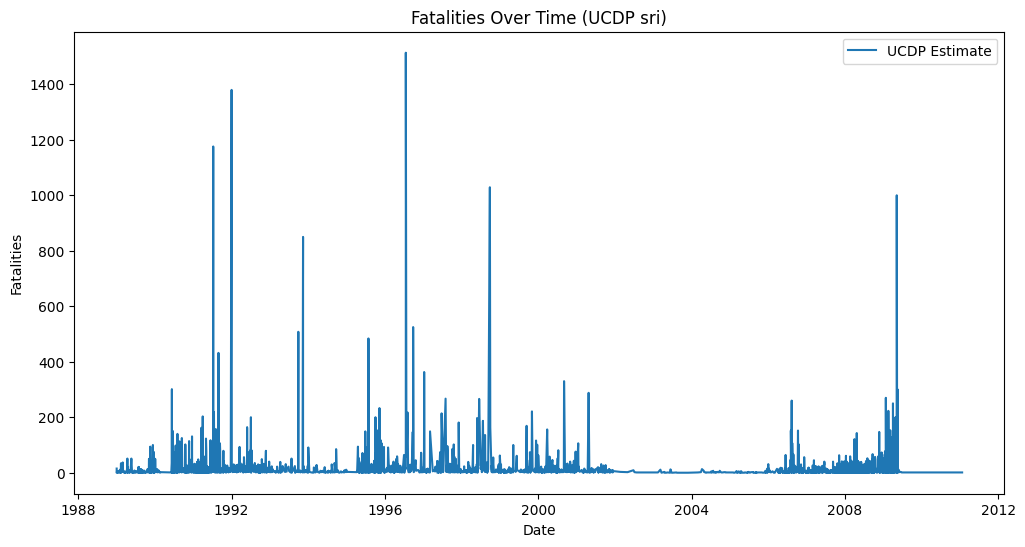

In [169]:
# plot of resampled data
ucleaner.plot()

In [170]:
# information from wikipedia: https://www.wikiwand.com/en/Category:Phases_of_the_Sri_Lankan_Civil_War

data = ucleaner.data
data = data.copy()
# not covered by data: ('23 July 1983', '29 July 1987')
tuples = [('23 July 1983', '29 July 1987'), ('June 10, 1990', 'January 1995'), ('19 April 1995','22 February 2002'), ('26 July 2006','18 May 2009')]

# Convert tuples to datetime ranges
date_ranges = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in tuples]

# Define a function to check if a date is within any wartime period and calculate days since war start
def in_wartime_and_days_since_start(date):
    days_since_start = np.nan
    for start, end in date_ranges:
        if start <= date:
            days_since_start = (date - start).days
        if start <= date <= end:
            return 1, days_since_start
    return 0, days_since_start

# Apply the function to the 'date_start' column in the data
data['wartime'], data['since_war_start'] = zip(*data['date_start'].apply(in_wartime_and_days_since_start))
print(data['wartime'].value_counts(normalize=True))


1    0.894645
0    0.105355
Name: wartime, dtype: float64


In [171]:
ucleaner.set_data(data)

dates range from 1989-01-31 to 2011-01-31


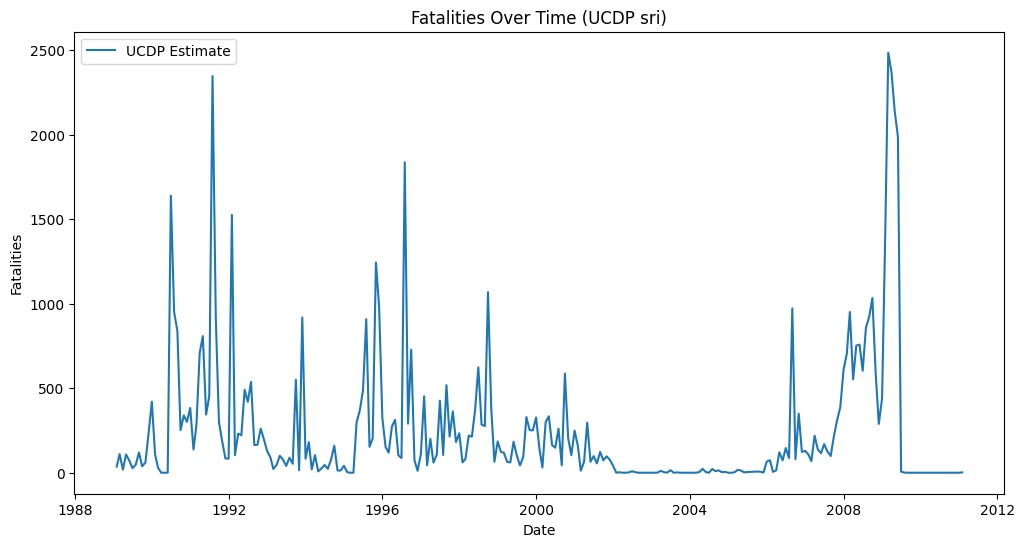

In [172]:
ucleaner.resample('M', war_var=True)
ucleaner.plot(use_resampled=True) 

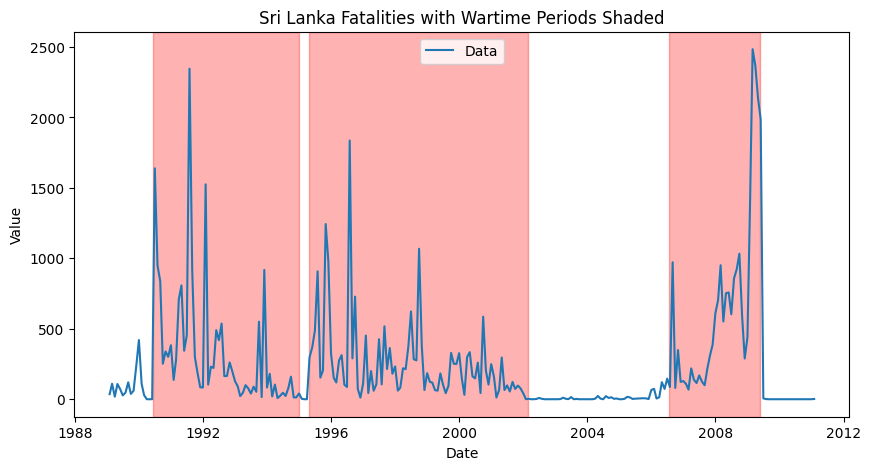

In [135]:
data = ucleaner.resampled
# Plotting the data with wartime periods shaded
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['best'], label='Data')  # Replace 'some_data_column' with the actual data column to plot
for start, end in date_ranges:
    if data[(data.index >= start) & (data.index <= end)].shape[0] > 0:
        plt.axvspan(start, end, color='red', alpha=0.3)
plt.legend()
plt.title('Sri Lanka Fatalities with Wartime Periods Shaded')
plt.xlabel('Date')
plt.ylabel('Value')  # Replace 'Value' with the actual description of the data column
plt.show()


In [175]:
data = ucleaner.resampled.copy()
data['avg_duration'] = data['avg_duration'].fillna(pd.Timedelta(seconds=0))
data['avg_duration'] = data['avg_duration'].dt.total_seconds().astype(int)
data.head()

,best,unique_conflicts,avg_duration,events_count,wartime,since_war_start
date_start,,,,,,
1989-01-31,36,4,6998400,9,0,2000.000000
1989-02-28,110,4,14400,12,0,2031.583333
1989-03-31,18,4,61714,7,0,2060.571429
1989-04-30,108,4,6171,14,0,2094.214286
1989-05-31,72,5,271542,7,0,2122.857143


In [176]:
def create_sliding_window(data, window_size):
    for i in range(1, window_size + 1):
        data[f'best_lag_{i}'] = data['best'].shift(i)
    return data.dropna()

window_size = 4  # 4-6 seems to be ideal
X = create_sliding_window(data, window_size)
X.head()

,best,unique_conflicts,avg_duration,events_count,wartime,since_war_start,best_lag_1,best_lag_2,best_lag_3,best_lag_4
date_start,,,,,,,,,,
1989-05-31,72,5,271542,7,0,2122.857143,108.0,18.0,110.0,36.0
1989-06-30,27,2,0,12,0,2152.416667,72.0,108.0,18.0,110.0
1989-07-31,47,3,7854,11,0,2187.090909,27.0,72.0,108.0,18.0
1989-08-31,120,4,100800,36,0,2214.722222,47.0,27.0,72.0,108.0
1989-09-30,38,3,31831,19,0,2246.210526,120.0,47.0,27.0,72.0


In [177]:
y = X['best']
y.head()

date_start
1989-05-31     72
1989-06-30     27
1989-07-31     47
1989-08-31    120
1989-09-30     38
Name: best, dtype: int64

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2472.8391266666636
